In [9]:
# import
import numpy as np
import cv2 as cv
import glob
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import os 
font = FontProperties(fname=os.environ['WINDIR']+'\\Fonts\\kaiu.ttf', size=16)

In [10]:
#定義像素大小1920*1080
w=1920
h=1080
IMAGE_SIZE=(w,h)

# 定義相機座標系(X_c, Y_c, Z_c)中的棋盤方格

row=6
col=9
objectPt = np.zeros((row*col,3), np.float32)
objectPt[:,:2] = np.mgrid[0:row,0:col].T.reshape(-1,2)

In [11]:
# 設定termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 取得照片(像素坐標系)中棋盤方格點(u,v)
def get_imgpt(images:[],row=6,col=9,show=True) -> list :
    imgpoints = [] # 2d points in image plane.
    # print(len(images))
    for fname in images:
        print("dealing ",fname)
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        if show:
            plt.figure(figsize=(20,20))
            plt.subplot(121)
            plt.imshow(img[:,:,::-1])
        

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (row,col), None)

        # If found, add object points, image points (after refining them)
        if ret == True:

            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            cv.drawChessboardCorners(img, (row,col), corners2, ret)
            if show:
                plt.subplot(122)
                plt.imshow(img[:,:,::-1])
        
        if show:
            plt.show()
    return imgpoints

In [12]:
# 讀取校正用照片
limgs=glob.glob(r'calibration/zed_tv/l/*.png')
rimgs=glob.glob(r'calibration/zed_tv/r/*.png')
print(len(limgs),len(rimgs))

3 3


dealing  calibration/zed_tv/l\Explorer_HD1080_SN30323411_10-59-39-l.png


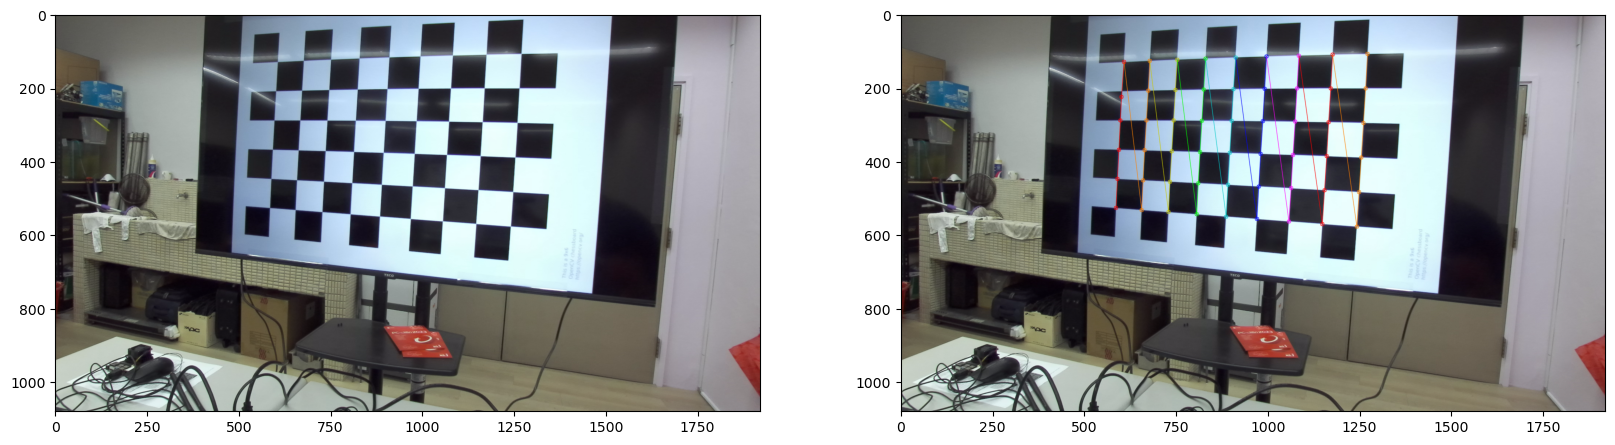

dealing  calibration/zed_tv/l\Explorer_HD1080_SN30323411_10-59-48-l.png


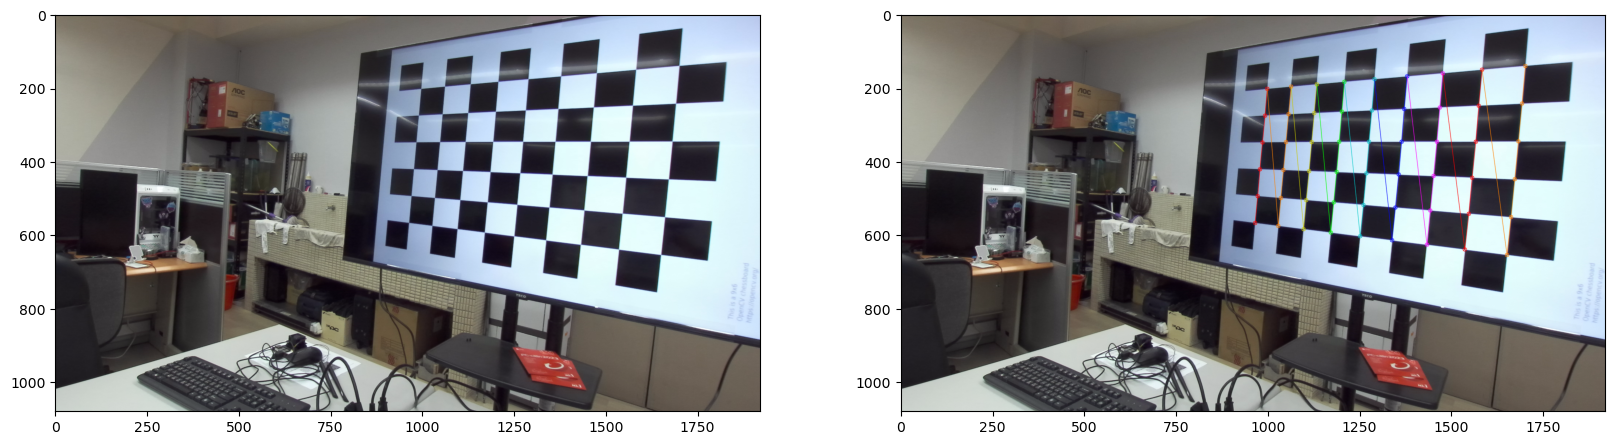

dealing  calibration/zed_tv/l\Explorer_HD1080_SN30323411_10-59-58-l.png


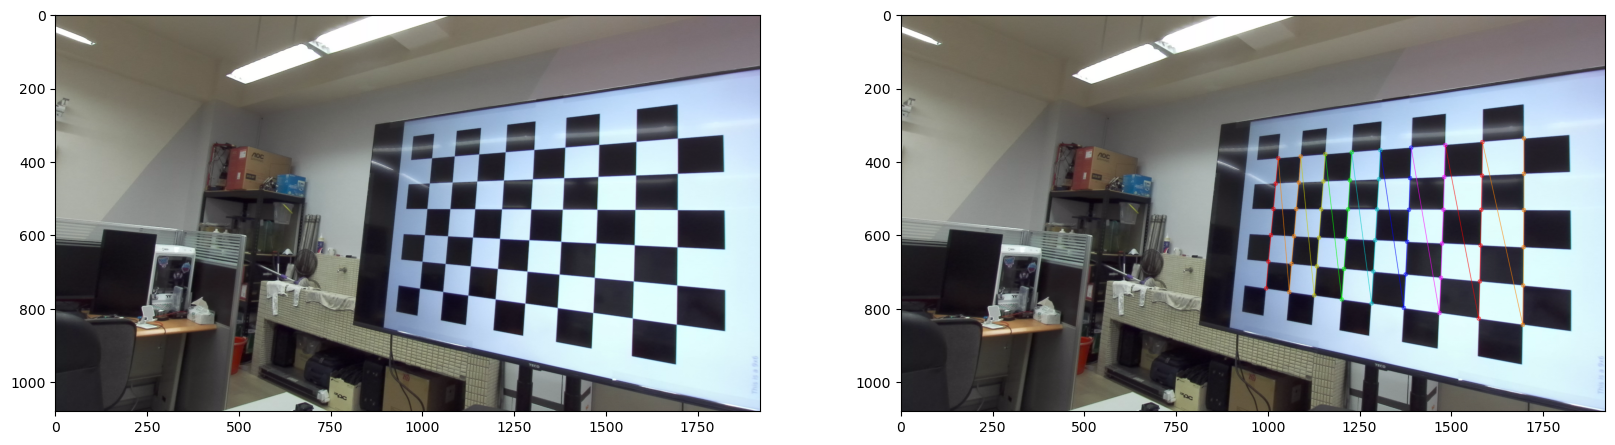

dealing  calibration/zed_tv/r\Explorer_HD1080_SN30323411_10-59-39-r.png


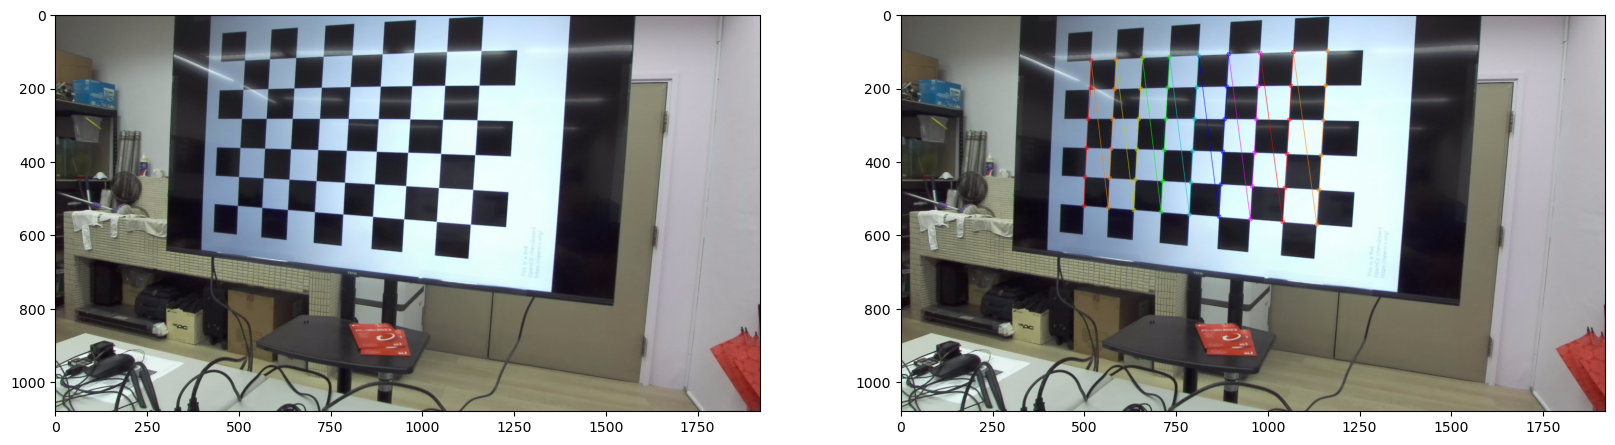

dealing  calibration/zed_tv/r\Explorer_HD1080_SN30323411_10-59-48-r.png


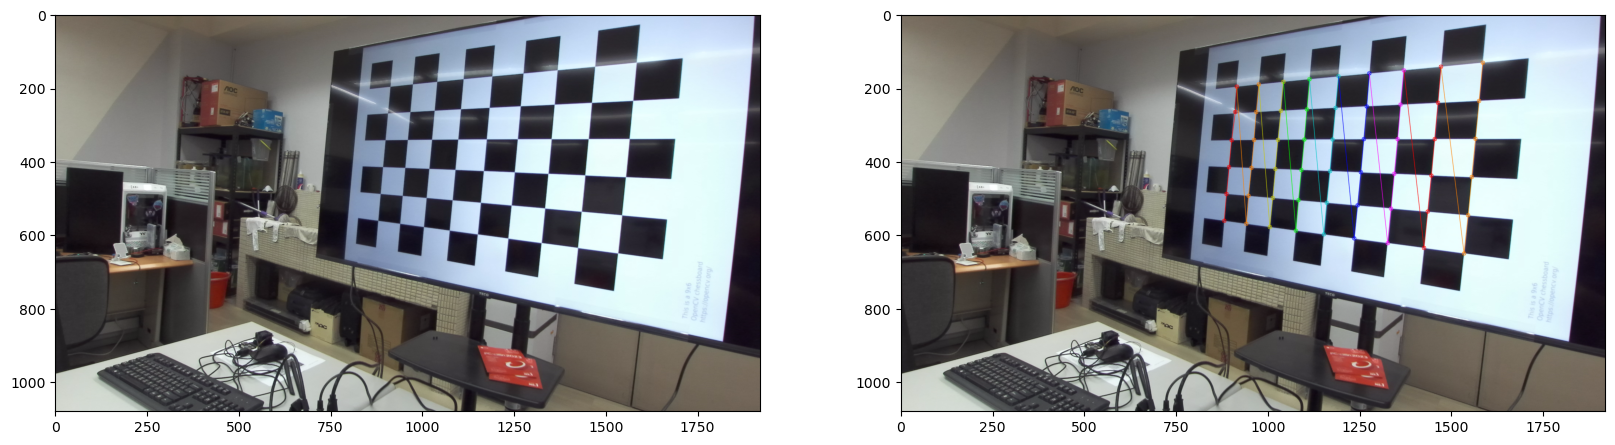

dealing  calibration/zed_tv/r\Explorer_HD1080_SN30323411_10-59-58-r.png


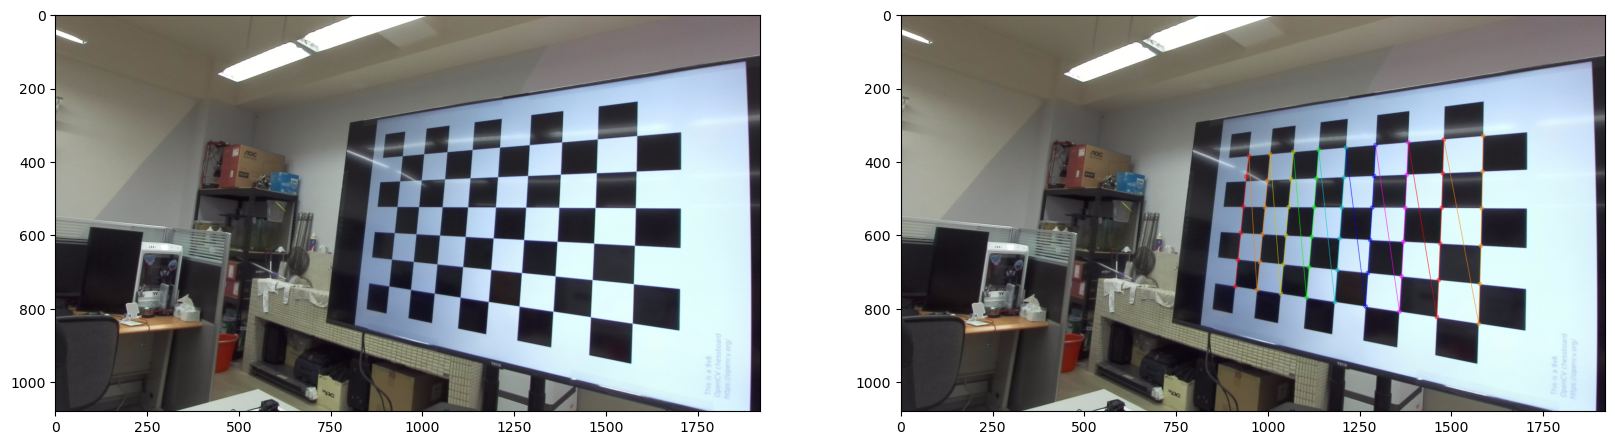

3 3 3


In [13]:
# 用相機座標系、像素坐標系的對應關係，取得立體相機校正
limgpts= get_imgpt(limgs,show=True)# 2d points in left image plane.
rimgpts=get_imgpt(rimgs,show=True)# 2d points in right image plane.
objpts = [objectPt]*len(limgpts) # 3d point in real world space
print(len(limgpts),len(rimgpts),len(objpts))
retval,cameraMatrix1,distCoeffs1,cameraMatrix2,distCoeffs2,R,T,E,F=cv.stereoCalibrate(objpts,limgpts,rimgpts,cameraMatrix1=None,distCoeffs1=None,cameraMatrix2=None,distCoeffs2=None,imageSize=IMAGE_SIZE,criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001),flags=0)

In [14]:
print(cameraMatrix1)
print(cameraMatrix2)

[[1.07351086e+03 0.00000000e+00 9.41425051e+02]
 [0.00000000e+00 1.07415045e+03 5.33730345e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.07328980e+03 0.00000000e+00 9.55457261e+02]
 [0.00000000e+00 1.07515370e+03 5.15967053e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [15]:
# 計算 Essential matrix

scale_factor = 1
new_size = (int(w*scale_factor),int(h*scale_factor))
R1,R2,P1,P2,Q = cv.stereoRectify(cameraMatrix1,distCoeffs1,cameraMatrix2,distCoeffs2,new_size,R,T)[0:5]
left_mapx,left_mapy   = cv.initUndistortRectifyMap(cameraMatrix1,distCoeffs1,R1,P1,new_size,cv.CV_32FC1)
right_mapx,right_mapy = cv.initUndistortRectifyMap(cameraMatrix2,distCoeffs2,R2,P2,new_size,cv.CV_32FC1)
print(Q)
print(new_size)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -9.66905563e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.23067039e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07465208e+03]
 [ 0.00000000e+00  0.00000000e+00  7.84632063e-01 -0.00000000e+00]]
(1920, 1080)


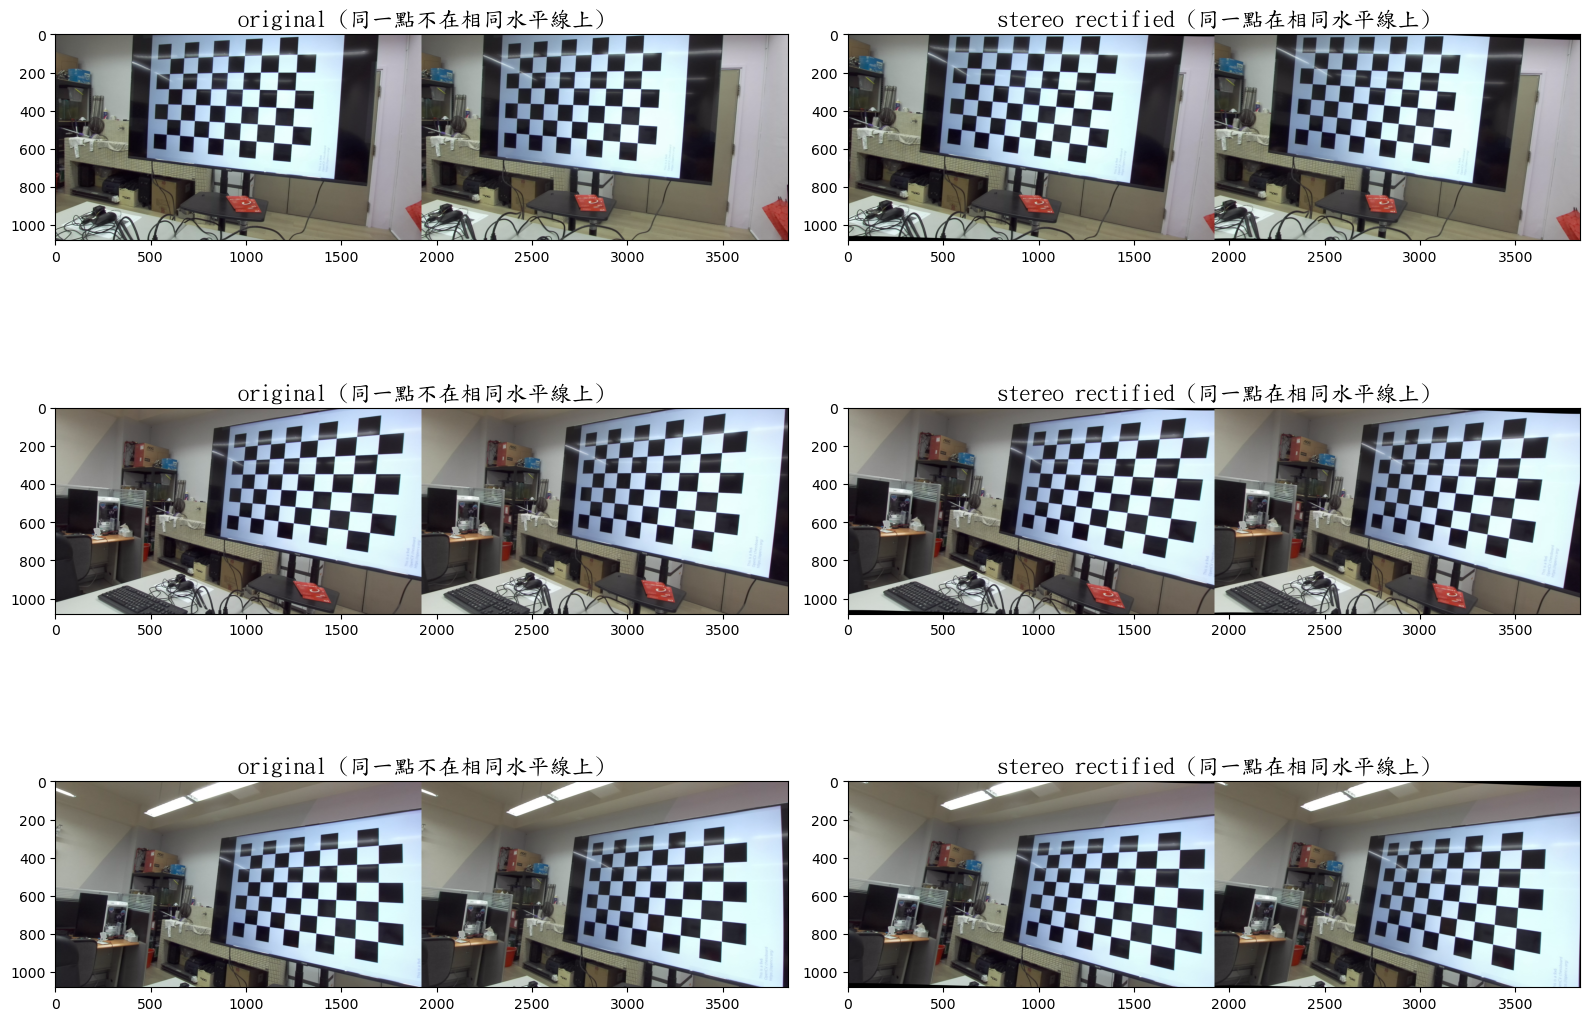

In [16]:
plt.figure(figsize=(16,4*len(limgs)))
for idx,(left_image, right_image) in enumerate(zip(limgs,rimgs)):
    left_image=cv.imread(left_image,cv.IMREAD_COLOR)
    right_image=cv.imread(right_image,cv.IMREAD_COLOR)
    undistorted_left  = cv.remap(left_image,left_mapx,left_mapy,cv.INTER_LINEAR)
    undistorted_right = cv.remap(right_image,right_mapx,right_mapy,cv.INTER_LINEAR)
    plt.subplot(len(limgs),2,2*idx+1)
    plt.imshow(np.concatenate([left_image,right_image],axis=1)[:,:,::-1])
    plt.title('original (同一點不在相同水平線上)',fontproperties=font)
    plt.subplot(len(limgs),2,2*idx+2)
    plt.imshow(np.concatenate([undistorted_left,undistorted_right],axis=1)[:,:,::-1])
    plt.title('stereo rectified (同一點在相同水平線上)',fontproperties=font)
  
plt.tight_layout()